In [283]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
import re
from torch.utils.data import Dataset, DataLoader

from config import DATA_FOLDER

# Data

In [284]:
df = pd.read_csv(DATA_FOLDER / "mobile phone price prediction.csv")
df = df.drop("Unnamed: 0", axis=1)

In [285]:
df.shape

(1370, 17)

In [286]:
df.head()

,Name,Rating,Spec_score,No_of_sim,Ram,Battery,Display,Camera,External_Memory,Android_version,Price,company,Inbuilt_memory,fast_charging,Screen_resolution,Processor,Processor_name
0,Samsung Galaxy F14 5G,4.65,68,"Dual Sim, 3G, 4G, 5G, VoLTE,",4 GB RAM,6000 mAh Battery,6.6 inches,50 MP + 2 MP Dual Rear &amp; 13 MP Front Camera,"Memory Card Supported, upto 1 TB",13,"9,999",Samsung,128 GB inbuilt,25W Fast Charging,2408 x 1080 px Display with Water Drop Notch,Octa Core Processor,Exynos 1330
1,Samsung Galaxy A11,4.20,63,"Dual Sim, 3G, 4G, VoLTE,",2 GB RAM,4000 mAh Battery,6.4 inches,13 MP + 5 MP + 2 MP Triple Rear &amp; 8 MP Fro...,"Memory Card Supported, upto 512 GB",10,"9,990",Samsung,32 GB inbuilt,15W Fast Charging,720 x 1560 px Display with Punch Hole,1.8 GHz Processor,Octa Core
2,Samsung Galaxy A13,4.30,75,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,5000 mAh Battery,6.6 inches,50 MP Quad Rear &amp; 8 MP Front Camera,"Memory Card Supported, upto 1 TB",12,"11,999",Samsung,64 GB inbuilt,25W Fast Charging,1080 x 2408 px Display with Water Drop Notch,2 GHz Processor,Octa Core
3,Samsung Galaxy F23,4.10,73,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,6000 mAh Battery,6.4 inches,48 MP Quad Rear &amp; 13 MP Front Camera,"Memory Card Supported, upto 1 TB",12,"11,999",Samsung,64 GB inbuilt,NaN,720 x 1600 px,Octa Core,Helio G88
4,Samsung Galaxy A03s (4GB RAM + 64GB),4.10,69,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,5000 mAh Battery,6.5 inches,13 MP + 2 MP + 2 MP Triple Rear &amp; 5 MP Fro...,"Memory Card Supported, upto 1 TB",11,"11,999",Samsung,64 GB inbuilt,15W Fast Charging,720 x 1600 px Display with Water Drop Notch,Octa Core,Helio P35


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1370 non-null   object 
 1   Rating             1370 non-null   float64
 2   Spec_score         1370 non-null   int64  
 3   No_of_sim          1370 non-null   object 
 4   Ram                1370 non-null   object 
 5   Battery            1370 non-null   object 
 6   Display            1370 non-null   object 
 7   Camera             1370 non-null   object 
 8   External_Memory    1370 non-null   object 
 9   Android_version    927 non-null    object 
 10  Price              1370 non-null   object 
 11  company            1370 non-null   object 
 12  Inbuilt_memory     1351 non-null   object 
 13  fast_charging      1281 non-null   object 
 14  Screen_resolution  1368 non-null   object 
 15  Processor          1342 non-null   object 
 16  Processor_name     1370 

In the above we've loaded our datasets, and taken a first look at them.

We can see that we have some relatively small datasets, with less than 1400 rows.

We have 17 columns. Price is the target variable, and the rest are features. We can see that all of the features are categorical, including the target. On closer inspection, we can definitely convert some of those to numerical features. There also a small amount of missing values, which we should also fill in.

The given column description is as follows:

- Name: This column contains the name of the mobile phone.
- Rating: This column contains the ratings given to the phone. the minimum rating is 0. and maximum rating is 5.
- Spec_score: This column contains the score given to the phone on the basic of its specifications. This minimum value is 0 and maximum value is 100.
- No_of_sim: This column contains whether the phone is dual sim, has 3g, 4g, 5g, volte.
- RAM: This column contains the information about the RAM of the phone
- Battery: This column provides information about battery specification of the phone.
- Display: This column contains information about the screen size of the phone.
- Camera: This column provides information about the camera, rear and front.
- External_Memory: This column contains information whether a device support external memory and
how much.
- Android_version: This column tells us about the android version of the phone.
- Price: Price of the phone.
- Company: The company to which the phone belongs.
- Inbuilt_memory: This column provides information about the inbuilt memory of the phone.
- fast_charging: It contains whether the device supports fast charging or not. if yes then how much.
- Screen_resolution: This describes the screen resolution of the phone.
- Processor: This column gives information about the processor of the phone.
- Processor_name: This column describes the name of the processor.

# Cleaning

In [288]:
df["Name"].describe()

count                                   1370
unique                                  1334
top       Realme Narzo N55 (6GB RAM + 128GB)
freq                                       3
Name: Name, dtype: object

In [289]:
df = df.drop("Name", axis=1)

For name, we can see that we have a unique value for almost every single row. I doubt the usefulness of this column on its own, especially since we have a company column already. So we drop it.

In [290]:
df = df.astype({"Rating": "float32", "Spec_score": "int32"})

The features above don't need more work other than setting the data type correctly.

In [291]:
df["No_of_sim"].value_counts()

No_of_sim
Dual Sim, 3G, 4G, 5G, VoLTE,             818
Dual Sim, 3G, 4G, VoLTE,                 419
Dual Sim, 3G, 4G, 5G, VoLTE, Vo5G,        91
Single Sim, 3G, 4G, 5G, VoLTE,            20
Dual Sim, 3G, 4G,                         13
Single Sim, 3G, 4G, VoLTE,                 6
No Sim Supported,                          1
Single Sim, 3G, 4G, 5G, VoLTE, Vo5G,       1
Dual Sim, 3G, VoLTE,                       1
Name: count, dtype: int64

In [292]:
# Remove trailing commas
df['No_of_sim'] = df['No_of_sim'].str.replace(r'\s*,\s*$', '', regex=True)

# Create new columns based on the presence of a feature
df['sim'] = df['No_of_sim'].str.contains('Dual Sim').astype(int) + df['No_of_sim'].str.contains('Single Sim').astype(int)
df['3g'] = df['No_of_sim'].str.contains('3G').astype(int)
df['4g'] = df['No_of_sim'].str.contains('4G').astype(int)
df['5g'] = df['No_of_sim'].str.contains('5G').astype(int)
df['volte'] = df['No_of_sim'].str.contains('VoLTE').astype(int)
df['vo5g'] = df['No_of_sim'].str.contains('Vo5G').astype(int)

# Set all to 0 if 'No Sim Supported'
df.loc[df['No_of_sim'].str.contains('No Sim Supported'), ['sim', '3g', '4g', '5g', 'volte', 'vo5g']] = 0

# Drop the original column
df = df.drop('No_of_sim', axis=1)

The feature above was more complicated. It contains sim card specs. I felt like this was more useful if we had them separated as new columns, so you can check for the specific features (e.g. 5G is pretty important to some).

In [293]:
df["Ram"].value_counts()

Ram
8 GB RAM                                     528
4 GB RAM                                     253
12 GB RAM                                    246
6 GB RAM                                     214
16 GB RAM                                     41
3 GB RAM                                      38
2 GB RAM                                      22
256 GB inbuilt                                 8
128 GB inbuilt                                 7
18 GB RAM                                      4
512 GB inbuilt                                 3
24 GB RAM                                      2
1 GB RAM                                       1
Helio G90T                                     1
1.5 GB RAM                                     1
6000 mAh Battery with 22.5W Fast Charging      1
Name: count, dtype: int64

In [294]:
# Split and take first value
df["Ram"] = df["Ram"].str.split(" ").str[0]

The ram column contains many categories, but these can easily be numerical. After all, more RAM is just better, objectively.

In [295]:
df["Camera"].value_counts()

Camera
50 MP + 2 MP Dual Rear &amp; 8 MP Front Camera                             81
Foldable Display, Dual Display                                             69
50 MP + 8 MP + 2 MP Triple Rear &amp; 16 MP Front Camera                   61
64 MP + 8 MP + 2 MP Triple Rear &amp; 16 MP Front Camera                   40
50 MP + 2 MP Dual Rear &amp; 16 MP Front Camera                            31
                                                                           ..
54 MP + 8 MP + 2 MP Triple Rear &amp; 16 MP Front Camera                    1
160 MP + 50 MP + 2 MP Triple Rear &amp; 50 MP + 2 MP Dual Front Camera      1
108 MP + 32 MP + 12 MP Triple Rear &amp; 50 MP + 2 MP Dual Front Camera     1
50 MP + 16 MP + 8 MP Triple Rear &amp; 32 MP + 8 MP Dual Front Camera       1
50 MP + 5 MP + 2 MP Triple Rear &amp; 32 MP Front Camera                    1
Name: count, Length: 347, dtype: int64

In [296]:
# Define a function to extract camera specs
def extract_camera_specs(camera_str):
    # Rear camera specs
    rear_match = re.findall(r'(\d+) MP', camera_str)
    if rear_match:
        rear_cameras = sorted(map(int, rear_match), reverse=True)
    else:
        rear_cameras = []
    
    # Front camera specs
    front_match = re.search(r'(\d+) MP Front Camera', camera_str)
    front_camera = int(front_match.group(1)) if front_match else 0
    
    return rear_cameras, front_camera

# Apply the function and create new columns
df['Rear_Cameras'], df['Front_Camera'] = zip(*df['Camera'].apply(extract_camera_specs))

# Fill new columns with the extracted values
# Extracting up to X rear camera specs
max_cameras = 3
for i in range(max_cameras):
    df[f'Rear_Camera_{i+1}'] = df['Rear_Cameras'].apply(lambda x: x[i] if i < len(x) else 0)

# Drop the temporary column
df.drop(columns=['Rear_Cameras'], inplace=True)
df = df.drop(columns=['Camera'])

The camera column is a little tricky. We can see that it's separated into front and rear camera's, with often multiple cameras for the rear camera. We'll first split it into front and rear cameras. Then afterwards, for each instance we extract the megapixels. 

With absence, we set it to 0.

In [297]:
df["Battery"].value_counts()

Battery
5000 mAh Battery     693
4500 mAh Battery     116
6000 mAh Battery     102
5000 mAh Battery      59
4000 mAh Battery      36
                    ... 
4821 mAh Battery       1
4730 mAh Battery       1
5700 mAh Battery       1
3760 mAh Battery       1
4500 mAh Battery       1
Name: count, Length: 89, dtype: int64

In [298]:
# Split and take first value
df["Battery"] = df["Battery"].str.split(" ").str[0]

With the battery column we split and take the first value, to get the battery capacity in mAh.

In [299]:
df["Display"].value_counts()

Display
6.7 inches     158
6.67 inches    151
6.78 inches    142
6.5 inches     122
6.6 inches      94
              ... 
5.6 inches       1
6.69 inches      1
12.1 inches      1
7.71 inches      1
10 inches        1
Name: count, Length: 89, dtype: int64

In [300]:
# Split and take first value
df["Display"] = df["Display"].str.split(" ").str[0]

With the display column we split and take the first value, to get the screen size in inches.

In [301]:
df["External_Memory"].value_counts()

External_Memory
Memory Card Supported, upto 1 TB                                               233
Memory Card (Hybrid), upto 1 TB                                                161
Memory Card Not Supported                                                      142
Android v13                                                                    107
Android v12                                                                    104
                                                                              ... 
48 MP + 12 MP Dual Rear &amp; 10 MP Front Camera                                 1
48 MP + 10.8 MP + 10.8 MP Triple Rear &amp; 9.5 MP + 8 MP Dual Front Camera      1
50 MP + 10.8 MP + 10.8 MP Triple Rear &amp; 12 MP + 12 MP Dual Front Camera      1
Memory Card Supported, upto 32 GB                                                1
50 MP + 48 MP + 8 MP Triple Rear &amp; 32 MP Front Camera                        1
Name: count, Length: 85, dtype: int64

In [302]:
# if Memory Card Not Supported, set it to 0, else 1
df["External_Memory"] = df["External_Memory"].str.contains("Memory Card Not Supported").astype(int)

There are many categories in the external memory column. However, in the end it boils down to whether the answer to external memory support is yes or no. Most consumers probably don't pay attention to the max amount supported. So, we split it into a binary column.

In [303]:
df["Android_version"].value_counts()

Android_version
13                   280
12                   202
14                   178
11                   127
10                    55
15                    17
10.0                  17
9.0 (Pie)             17
4.0                    8
8.1 (Oreo)             5
6.0 (Marshmallow)      3
3.0                    3
2.0                    3
3.1                    2
7.1.1 (Nougat)         2
5.0                    1
3.0 (Honeycomb)        1
5.1 (Lollipop)         1
2                      1
3                      1
9 (Pie)                1
8.0 (Oreo)             1
4.1                    1
Name: count, dtype: int64

In [304]:
df = df.drop("Android_version", axis=1)

The android version contains a few categories. It doesn't seem very relevant to the price though, so we'll drop it.

In [305]:
df["company"].value_counts()

company
Vivo        186
Realme      186
Samsung     181
Motorola    127
Xiaomi       90
Honor        88
Poco         75
OnePlus      75
Huawei       62
iQOO         57
OPPO         38
Oppo         27
TCL          26
Google       23
Asus         21
POCO         19
Lava         19
Nothing      15
Lenovo       14
Tecno        13
itel         12
LG            6
Gionee        5
Itel          3
IQOO          1
Coolpad       1
Name: count, dtype: int64

This column seems fine, other than needing to be encoded.

In [306]:
df["Inbuilt_memory"].value_counts()

Inbuilt_memory
128 GB inbuilt    644
256 GB inbuilt    405
64 GB inbuilt     184
512 GB inbuilt     59
32 GB inbuilt      48
1 TB inbuilt        5
16 GB inbuilt       3
Octa Core           1
258 GB inbuilt      1
8 GB inbuilt        1
Name: count, dtype: int64

In [307]:
# Remove whitespace
df['Inbuilt_memory'] = df['Inbuilt_memory'].str.strip()

# Drop rows with 'Octa Core'
df = df[df['Inbuilt_memory'].str.lower() != 'octa core']

# Extract memory size by splitting and taking the first element
df['Inbuilt_memory'] = df['Inbuilt_memory'].str.split().str[0]

# Set columns with 1 (terabyte) to 1024
df.loc[df['Inbuilt_memory'] == '1', 'Inbuilt_memory'] = 1024

The inbuilt memory column is mostly fine, but it contains a rogue processor value. We remove that, and then we can convert it to an integer.

In [308]:
df["fast_charging"].value_counts()

fast_charging
18W Fast Charging      157
33W Fast Charging      144
67W Fast Charging      101
25W Fast Charging       97
80W Fast Charging       78
100W Fast Charging      70
66W Fast Charging       66
120W Fast Charging      65
15W Fast Charging       61
44W Fast Charging       61
45W Fast Charging       58
65W Fast Charging       50
30W Fast Charging       44
10W Fast Charging       39
Fast Charging           39
150W Fast Charging      24
22.5W Fast Charging     20
68W Fast Charging       20
40W Fast Charging       17
35W Fast Charging       14
125W Fast Charging      12
20W Fast Charging       11
200W Fast Charging       7
240W Fast Charging       3
55W Fast Charging        3
90W Fast Charging        3
88W Fast Charging        3
50W Fast Charging        2
250W Fast Charging       2
27W Fast Charging        2
57W Fast Charging        1
60W Fast Charging        1
08W Fast Charging        1
68.2W Fast Charging      1
135W Fast Charging       1
70W Fast Charging        1
Water Drop Not

In [309]:
# If fast charging has any value, set to 1, otherwise 0
df["fast_charging"] = df["fast_charging"].apply(lambda x: 0 if pd.isna(x) else 1)

The fast charging column can be converted to a binary column.

In [310]:
df["Screen_resolution"].value_counts()

Screen_resolution
1080 x 2400 px                                 357
720 x 1600 px Display with Water Drop Notch    100
1080 x 2412 px                                  77
720 x 1600 px                                   65
1080 x 2340 px                                  50
                                              ... 
2340 x 1080 px                                   1
1080 x 1920 px Display                           1
720 x 1600 px Display with Large Notch           1
540 x 960 px Display                             1
720 x 1640 px Display with Water Drop Notch      1
Name: count, Length: 141, dtype: int64

In [311]:
# Split on x letter
df["screen_width"] = df["Screen_resolution"].str.split(" x ").str[0]
df["screen_height"] = df["Screen_resolution"].str.split(" x ").str[1]
df["screen_height"] = df["screen_height"].str.split(" ").str[0]
df = df.drop("Screen_resolution", axis=1)

The screen resolution column can be converted to two columns, one for the width and one for the height.

In [312]:
df["Processor"].value_counts()

Processor
Octa Core              1237
Octa Core Processor      75
Quad Core                11
1.6 GHz Processor         3
Deca Core                 3
2 GHz Processor           2
Nine-Cores                2
Nine Core                 2
Nine Cores                2
1.8 GHz Processor         1
Deca Core Processor       1
1.3 GHz Processor         1
2.3 GHz Processor         1
128 GB inbuilt            1
Name: count, dtype: int64

In [313]:
# Remove whitespace
df['Processor'] = df['Processor'].str.strip()

# Harmonize certain processor names
df['Processor'] = df['Processor'].str.replace('Octa Core Processor', 'Octa Core')
df['Processor'] = df['Processor'].str.replace('Nine-Cores', 'Nine Core')
df['Processor'] = df['Processor'].str.replace('Nine Cores', 'Nine Core')
df['Processor'] = df['Processor'].str.replace('Deca Core Processor', 'Deca Core')

# Drop rows with invalid values
df = df[df['Processor'].str.lower() != '128 gb inbuilt']
df = df[df['Processor'].str.lower() != '1.3 ghz processor']
df = df[df['Processor'].str.lower() != '1.6 ghz processor']
df = df[df['Processor'].str.lower() != '1.8 ghz processor']
df = df[df['Processor'].str.lower() != '2 ghz processor']
df = df[df['Processor'].str.lower() != '2.3 ghz processor']

# Convert values to core count (octa = 8, deci = 10, etc.)
df['Processor'] = df['Processor'].str.split().str[0]
df.loc[df['Processor'] == 'Quad', 'Processor'] = 4
df.loc[df['Processor'] == 'Octa', 'Processor'] = 8
df.loc[df['Processor'] == 'Deca', 'Processor'] = 10
df.loc[df['Processor'] == 'Nine', 'Processor'] = 9

# Rename
df = df.rename(columns={'Processor': 'core_count'})

In the processor column we have a bunch of categories, and all quite distinct. We also spot another rogue value, so we remove the row there.

The first thing we can do is harmonize this column, as many names are similar.

Secondarily, we have some cells which don't describe the core count, but the clock speed. We can remove these rows as we have no good way of infering the count.

In [314]:
df["Processor_name"].value_counts()

Processor_name
Snapdragon 8+ Gen1    58
Snapdragon 8 Gen2     55
Snapdragon 8 Gen3     44
Snapdragon 695        36
Snapdragon 680        34
                      ..
Dimensity 8000         1
Dimensity  1100        1
Dimensity 920          1
Snapdragon  765G       1
Helio A25              1
Name: count, Length: 272, dtype: int64

In [315]:
df = df.drop("Processor_name", axis=1)

The processor name doesn't seem useful when we have core count already. Any other processor specs would require an internet search anyway, which we'll not do here.

In [316]:
df["Price"].describe()

count       1360
unique       449
top       29,990
freq          37
Name: Price, dtype: object

In [317]:
# Remove commas
df['Price'] = df['Price'].str.replace(',', '')
# to numeric
df['Price'] = pd.to_numeric(df['Price'])

The price column is mostly fine, but it is in text format, seen by the commas. We quickly convert this to a numeric value.

In [318]:
# check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Inbuilt_memory    18
core_count        27
screen_height      1
dtype: int64

In [319]:
# Fill in cells
df["Inbuilt_memory"] = df["Inbuilt_memory"].fillna(0)

# Drop rows
df = df.dropna()

We now have 3 columns with missing values.

In case of inbuilt memory, we can assume that this phone only supports external memory, so we'll fill the values with 0.

For the others, we'll remove the rows.

In [320]:
# Set all column names to lower case
df.columns = df.columns.str.lower()

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1369
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rating           1332 non-null   float32
 1   spec_score       1332 non-null   int32  
 2   ram              1332 non-null   object 
 3   battery          1332 non-null   object 
 4   display          1332 non-null   object 
 5   external_memory  1332 non-null   int32  
 6   price            1332 non-null   int64  
 7   company          1332 non-null   object 
 8   inbuilt_memory   1332 non-null   object 
 9   fast_charging    1332 non-null   int64  
 10  core_count       1332 non-null   object 
 11  sim              1332 non-null   int32  
 12  3g               1332 non-null   int32  
 13  4g               1332 non-null   int32  
 14  5g               1332 non-null   int32  
 15  volte            1332 non-null   int32  
 16  vo5g             1332 non-null   int32  
 17  front_camera     13

In [322]:
encoder = OneHotEncoder()

# Lower values
df["company"] = df["company"].str.lower()

# Encode company column
encoder_df = pd.DataFrame(encoder.fit_transform(df[['company']]).toarray())
encoder_df.columns = encoder.get_feature_names_out(['company'])
df = df.join(encoder_df)
df = df.drop("company", axis=1)

We only have 1 categorical column left at this point, the company that made the phone. We perform one hot encoding, as we have no specific order to the values.

In [323]:
# Convert object columns to numeric
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')
    
# Set to 32 bit float
df = df.astype("float32")

C:\Users\Michael\AppData\Local\Temp\ipykernel_6164\908880838.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


We do some more dtype and name cleaning on the columns, and then we move on to encoding.

In [324]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head(3)

,rating,spec_score,ram,battery,display,external_memory,price,inbuilt_memory,fast_charging,core_count,...,company_nothing,company_oneplus,company_oppo,company_poco,company_realme,company_samsung,company_tcl,company_tecno,company_vivo,company_xiaomi
0,0.90,0.464286,0.005871,0.476744,0.276316,0.0,0.014656,0.1250,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.35,0.553571,0.005871,0.476744,0.250000,0.0,0.024269,0.0625,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.35,0.482143,0.005871,0.360465,0.263158,0.0,0.024269,0.0625,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Lastly we normalize the data, as some of our values are quite large, which can cause issues during training.

In [325]:
# reset index
df = df.reset_index(drop=True)

In [326]:
# fill nan with 0
df = df.fillna(0)

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            1332 non-null   float32
 1   spec_score        1332 non-null   float32
 2   ram               1332 non-null   float32
 3   battery           1332 non-null   float32
 4   display           1332 non-null   float32
 5   external_memory   1332 non-null   float32
 6   price             1332 non-null   float32
 7   inbuilt_memory    1332 non-null   float32
 8   fast_charging     1332 non-null   float32
 9   core_count        1332 non-null   float32
 10  sim               1332 non-null   float32
 11  3g                1332 non-null   float32
 12  4g                1332 non-null   float32
 13  5g                1332 non-null   float32
 14  volte             1332 non-null   float32
 15  vo5g              1332 non-null   float32
 16  front_camera      1332 non-null   float32


Our dataset is now cleaned.

# Model

## Preparation

In [328]:
EPOCHS = 60
BATCH_SIZE = 12

We have now cleaned our dataset quite a bit. Next is splitting it into features and target. 

In [329]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [330]:
y_train = train["price"]
y_test = test["price"]
X_train = train.drop("price", axis=1)
X_test = test.drop("price", axis=1)

In [331]:
# convert to torch dataset
class PhoneDataset(Dataset):
    def __init__(self, X: pd.Series, y: pd.Series):
        self.X = torch.from_numpy(X.to_numpy()).float()
        self.y = torch.from_numpy(y.to_numpy()).float().unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [332]:
train_dataset = PhoneDataset(X_train, y_train)
test_dataset = PhoneDataset(X_test, y_test)

In [333]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

We now have all of our variables, and we'll be ready to train our model.

## Model

In [334]:
class MyModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Above is a simple deep regression model. It consists of 4 fully connected layers, with ReLU activation functions.

In [335]:
input_dim = X_train.shape[1]
model = MyModel(input_dim)

loss_fun =  nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training

In [336]:
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i > 0:
        break
    print(X_batch[0].tolist())
    print(y_batch[0].tolist())

[0.34999990463256836, 0.6785714030265808, 0.24853229522705078, 0.33895349502563477, 0.2855263352394104, 0.0, 0.0, 1.0, 0.6666666865348816, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.21666668355464935, 0.23999999463558197, 0.203125, 0.25999999046325684, 0.3737373948097229, 0.6387097239494324, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.22611036896705627]


In [337]:
loss_epoch = []
val_loss_epoch = []
for epoch in range(EPOCHS):
    loss_list = []
    val_loss_list = []

    # training
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        
        loss = loss_fun(y_pred, y_batch)
        loss_list.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    # testing
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            val_loss = loss_fun(y_pred, y_batch)
            val_loss_list.append(val_loss.item())
        
    print(f"Epoch: {epoch}, loss: {np.nanmean(loss_list)}, val_loss: {np.nanmean(val_loss_list)}")
    loss_epoch.append(np.nanmean(loss_list))
    val_loss_epoch.append(np.nanmean(val_loss_list))
        

Epoch: 0, loss: 0.054278945294601234, val_loss: 0.020748900543169482
Epoch: 1, loss: 0.018938717262275265, val_loss: 0.016848935006672273
Epoch: 2, loss: 0.017083090989002854, val_loss: 0.015208763981480961
Epoch: 3, loss: 0.015460128953492039, val_loss: 0.01345046687081618
Epoch: 4, loss: 0.013913449649489746, val_loss: 0.012069626437986026
Epoch: 5, loss: 0.012664870035918326, val_loss: 0.011013247487742616
Epoch: 6, loss: 0.011412569591147679, val_loss: 0.009806971374453733
Epoch: 7, loss: 0.010125272529293898, val_loss: 0.008321848455006662
Epoch: 8, loss: 0.009480932197700976, val_loss: 0.007263203556446925
Epoch: 9, loss: 0.00843456413157368, val_loss: 0.0064960272233609275
Epoch: 10, loss: 0.007738446581355306, val_loss: 0.005873737289853718
Epoch: 11, loss: 0.007110631211106194, val_loss: 0.005195326737442013
Epoch: 12, loss: 0.006622257399807025, val_loss: 0.005046988326205831
Epoch: 13, loss: 0.006216175794690387, val_loss: 0.004690659429837504
Epoch: 14, loss: 0.005957793336

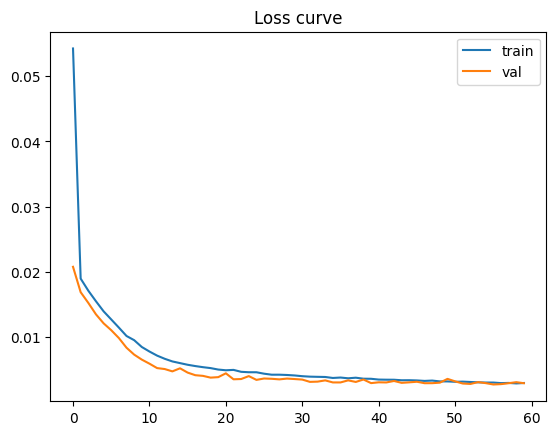

In [338]:
# Loss curves
plt.plot(loss_epoch, label="train")
plt.plot(val_loss_epoch, label="val")
plt.legend()
plt.title("Loss curve")
plt.show()

In [339]:
# R2 Score
scores = []
model.eval()
with torch.no_grad():

    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        
        y_pred = y_pred.numpy().reshape(-1)
        y_batch = y_batch.numpy().reshape(-1)
        scores.append(r2_score(y_batch, y_pred))
    
    r2_total = np.mean(scores)
    print(f"R2 Score: {r2_total}")

R2 Score: 0.6463584407516147


We now have a trained model! It's not very good however, but that's fine, as it wasn't the point anyway. 